In [1]:
'''
Código criado por Júlia Nogueira em 28/01/2020
Atualizado pela última vez em 17/11/2021

Objetivo: Aplicação de Redes Neuronais MLP a um problema de classificação binária:
Determinação da Presença de Azeótropo em Misturas Binárias Contendo Metanol e Compostos Orgânicos à Pressão Atmosférica.

Utiliza os dados do trabalho: 
"Neural Network Model for Binary Azeotrope with Methanol at 1 Atmosphere (Partin, 1993)"

'''

'\nCódigo criado por Júlia Nogueira em 28/01/2020\nAtualizado pela última vez em 17/11/2021\n\nObjetivo: Aplicação de Redes Neuronais MLP a um problema de classificação binária:\nDeterminação da Presença de Azeótropo em Misturas Binárias Contendo Metanol e Compostos Orgânicos à Pressão Atmosférica.\n\nUtiliza os dados do trabalho: \n"Neural Network Model for Binary Azeotrope with Methanol at 1 Atmosphere (Partin, 1993)"\n\n'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


In [3]:
# Leitura do arquivo
df = pd.read_csv('azeotropo_python.csv', sep=';')

# Salvando o header
header_list = list(df.columns)  

# Embaralhando os dados e separação em treino e teste
df.sample(frac=1)
df_train, df_test = train_test_split(df, test_size=0.15, random_state=124)

In [4]:
# Separação dos dados em entradas e saída, e transformando a saída em categórica
df_train_x = df_train.drop('Azeo', axis=1)  # Removendo a coluna do output
df_train__y = np.array(df_train['Azeo'])
df_train_y = to_categorical(df_train__y, num_classes=2)

df_test_x = df_test.drop('Azeo', axis=1)  # Removendo a coluna do output
df_test__y = np.array(df_test['Azeo'])
df_test_y = to_categorical(df_test__y, num_classes=2)

In [5]:
# Normalização dos dados
scaler = StandardScaler().fit(df_train_x)
df_train_x = scaler.transform(df_train_x)
df_test_x = scaler.transform(df_test_x)

In [6]:
# Criação da rede [ entradas - 14 - 14 - 2 ]
input_dim = len(header_list)-1
model = Sequential()
model.add(Dense(14, input_dim=input_dim, activation='tanh'))
model.add(Dense(14, activation='exponential'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 30        
Total params: 450
Trainable params: 450
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Treinamento
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Bétodo de treinamento early stopping salvando o melhor modelo com checkpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('MLP_azeotropo_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(df_train_x, df_train_y, epochs=500, batch_size=10, verbose=1, validation_split=0.2, callbacks=[es, mc])
saved_model = load_model('MLP_azeotropo_best_model.h5')

# Resultado Treino
predictions_train = saved_model.predict_classes(df_train_x)

# Teste
predictions = saved_model.predict_classes(df_test_x)

Train on 58 samples, validate on 15 samples
Epoch 1/500
58/58 [==============================] - 0s 4ms/step - loss: 1.0511 - accuracy: 0.5517 - val_loss: 0.8179 - val_accuracy: 0.7333

Epoch 00001: val_accuracy improved from -inf to 0.73333, saving model to MLP_azeotropo_best_model.h5
Epoch 2/500
58/58 [==============================] - 0s 345us/step - loss: 0.9696 - accuracy: 0.5517 - val_loss: 0.7771 - val_accuracy: 0.7333

Epoch 00002: val_accuracy did not improve from 0.73333
Epoch 3/500
58/58 [==============================] - 0s 327us/step - loss: 0.8928 - accuracy: 0.5345 - val_loss: 0.7472 - val_accuracy: 0.7333

Epoch 00003: val_accuracy did not improve from 0.73333
Epoch 4/500
58/58 [==============================] - 0s 293us/step - loss: 0.8302 - accuracy: 0.5862 - val_loss: 0.7273 - val_accuracy: 0.6667

Epoch 00004: val_accuracy did not improve from 0.73333
Epoch 5/500
58/58 [==============================] - 0s 310us/step - loss: 0.7783 - accuracy: 0.6034 - val_loss: 0.7

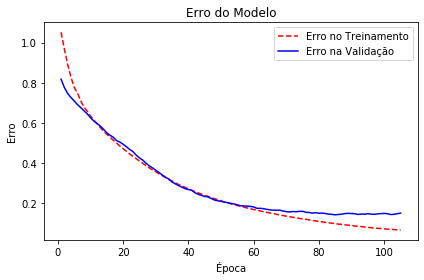

In [8]:
# Gráfico treinamento e validação - Avaliação early stopping
training_loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(1, len(training_loss) + 1)

plt.figure()
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Erro no Treinamento', 'Erro na Validação'])
plt.xlabel('Época')
plt.ylabel('Erro')
plt.title('Erro do Modelo')
plt.tight_layout()
plt.savefig('MLP_azeotropo_modelloss.png')
plt.show()
plt.close()

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87        30
           1       0.95      0.86      0.90        43

    accuracy                           0.89        73
   macro avg       0.89      0.90      0.89        73
weighted avg       0.90      0.89      0.89        73

Matriz de Confusão:
 [[37  6]
 [ 2 28]]


<Figure size 432x288 with 0 Axes>

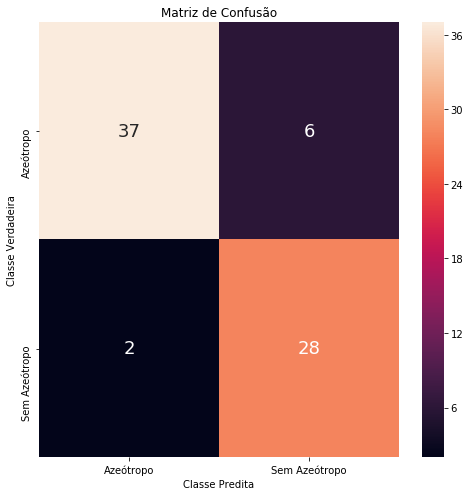

In [9]:
# Matriz de confusão e relatório de classificação - Treino
class_report_train = classification_report(df_train__y, predictions_train)
print('Relatório de Classificação:\n', class_report_train)

conf_mat_train = confusion_matrix(df_train__y, predictions_train, labels=[1, 0])
print('Matriz de Confusão:\n', conf_mat_train)

# Gráfico matriz de confusão
LABELS = ["Azeótropo", "Sem Azeótropo"]

plt.figure()
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, annot_kws={"size": 18}, fmt="d")
plt.title("Matriz de Confusão")
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.savefig('MLP_azeotropo_confmat_train.png')
plt.show()
plt.close()

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        10

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13

Matriz de Confusão:
 [[10  0]
 [ 0  3]]


<Figure size 432x288 with 0 Axes>

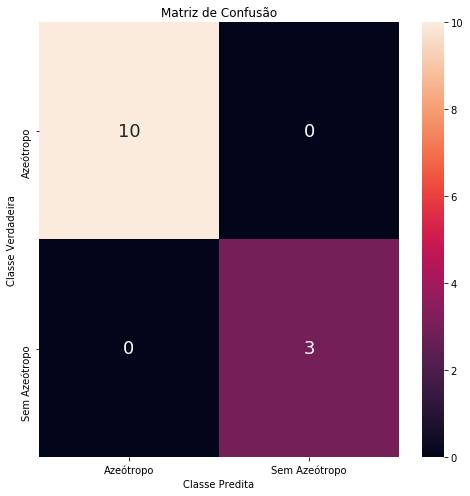

In [10]:
# Matriz de confusão e relatório de classificação - Teste
class_report = classification_report(df_test__y, predictions)
print('Relatório de Classificação:\n', class_report)

conf_mat = confusion_matrix(df_test__y, predictions, labels=[1, 0])
print('Matriz de Confusão:\n', conf_mat)

# Gráfico matriz de confusão
LABELS = ["Azeótropo", "Sem Azeótropo"]

plt.figure()
plt.figure(figsize=(7, 7))
sns.heatmap(conf_mat, xticklabels=LABELS, yticklabels=LABELS, annot=True, annot_kws={"size": 18}, fmt="d")
plt.title("Matriz de Confusão")
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.savefig('MLP_azeotropo_confmat.png')
plt.show()
plt.close()